WNixalo | 20181125

---

This notebook is an attempt to breach a score of 0.93 on the private leaderboard with ResNet34, using aggressive learning rates and extra progressive resizing. 2 versions of a model are trained, one with an extra cycle.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
__version__ # fastai

'1.0.28'

## Data

In [3]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True); #path

In [4]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [5]:
np.random.seed(0)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' '))
data = (src.transform(tfms, size=64)
       .databunch()
       .normalize(imagenet_stats))

In [19]:
arch = models.resnet34
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn   = create_cnn(data, arch, metrics=[acc_02, f_score])

In [12]:
# torch.save(learn.data.c2i, 'c2i-20181125.pkl') # save the class-index mappings
learn.data.c2i = torch.load('c2i-20181125.pkl') # load class-index mappings

## Training

I'm running this one final time -- trying to go by the heuristics I picked up in fast.ai.

### size 64 stage 1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


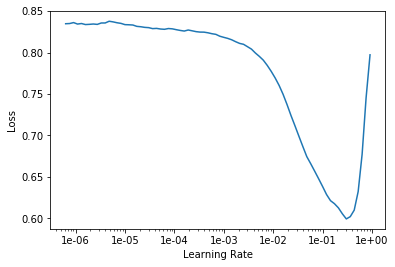

In [22]:
learn.lr_find(); learn.recorder.plot()

In [23]:
lr = 1e-1/5

In [24]:
learn.fit_one_cycle(6, slice(lr)) # oh cool: fastai by default uses slice(None, 0.003, None) for max_lr

Total time: 02:53
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.131712    0.113049    0.942717         0.901184  (00:28)
2      0.127153    0.115521    0.941780         0.897549  (00:30)
3      0.121411    0.109811    0.942187         0.906433  (00:28)
4      0.116218    0.107592    0.946895         0.908249  (00:28)
5      0.107559    0.098026    0.948756         0.914168  (00:28)
6      0.102131    0.095944    0.952018         0.918188  (00:28)



In [25]:
learn.save('rn34-stg1-sz64-final6')

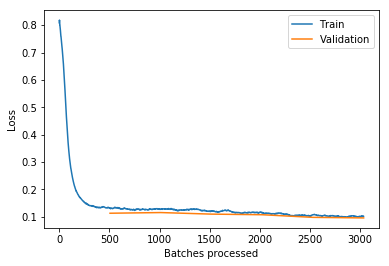

In [26]:
learn.recorder.plot_losses()

### size 64 stage 2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


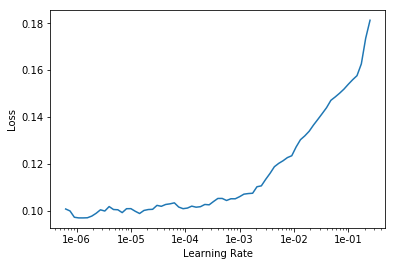

In [27]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [29]:
lr

0.02

In [34]:
lr = lr/5; lr

0.004

In [35]:
learn.lr_range(slice(lr/9, lr))

array([0.000444, 0.001333, 0.004   ])

In [36]:
learn.fit_one_cycle(6, slice(lr/9, lr)) 

Total time: 04:09
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.118241    0.113464    0.943066         0.896367  (00:41)
2      0.113990    0.110436    0.944301         0.901082  (00:41)
3      0.111601    0.101115    0.949875         0.911714  (00:41)
4      0.103748    0.096665    0.948312         0.916559  (00:41)
5      0.097015    0.092579    0.954750         0.921715  (00:41)
6      0.092409    0.090950    0.953864         0.922494  (00:41)



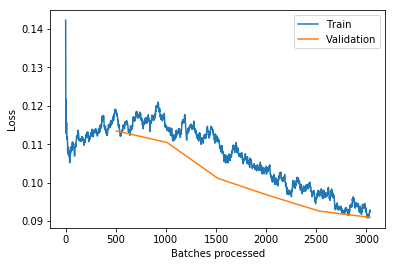

In [37]:
learn.recorder.plot_losses()

In [38]:
# learn.save('rn34-stg2-sz64-final6')
# learn.load('rn34-stg2-sz64-final6')

In [39]:
learn.fit_one_cycle(6, slice(lr/9, lr)) 

Total time: 04:09
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.099763    0.095288    0.950907         0.916526  (00:41)
2      0.105469    0.103381    0.946234         0.911681  (00:41)
3      0.102355    0.099382    0.949300         0.917228  (00:41)
4      0.097080    0.094354    0.954751         0.919067  (00:41)
5      0.093143    0.091628    0.955739         0.921459  (00:41)
6      0.090578    0.089722    0.956008         0.924125  (00:41)



In [40]:
learn.save('rn34-stg2x-sz64-final6')

### size 128 stage 1

In [41]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


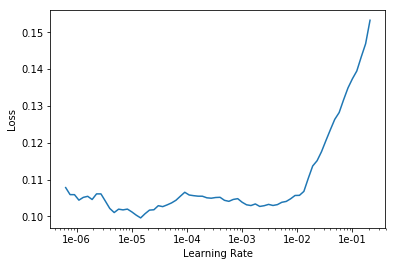

In [42]:
learn.lr_find(); learn.recorder.plot()

In [45]:
lr

0.004

In [46]:
learn.fit_one_cycle(6, slice(lr))

Total time: 07:50
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.096649    0.100539    0.953806         0.911996  (01:18)
2      0.105096    0.104120    0.946212         0.911430  (01:18)
3      0.098903    0.105571    0.951016         0.917061  (01:18)
4      0.094080    0.092322    0.953973         0.918271  (01:18)
5      0.090629    0.085901    0.955637         0.925427  (01:18)
6      0.086393    0.084449    0.957367         0.927392  (01:18)



In [50]:
learn.save('rn34-stg1-sz128-final6')

### size 128 stage 2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


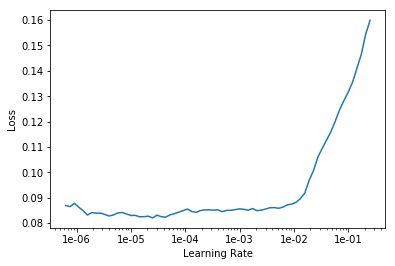

In [51]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [53]:
# new d-lr:
learn.lr_range(slice(lr/9, lr)) # lrs: lr/18, lr/6, lr/2; 5.5e-4, 1.6e-3, 5e-3

array([0.000444, 0.001333, 0.004   ])

In [54]:
learn.fit_one_cycle(6, slice(lr/9, lr)) 

Total time: 07:49
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.088104    0.086526    0.957490         0.924749  (01:17)
2      0.095010    0.092126    0.959830         0.921628  (01:18)
3      0.093534    0.094934    0.951757         0.919698  (01:18)
4      0.088143    0.086201    0.958900         0.925803  (01:18)
5      0.082145    0.084584    0.959300         0.927880  (01:18)
6      0.084492    0.083393    0.959380         0.928247  (01:18)



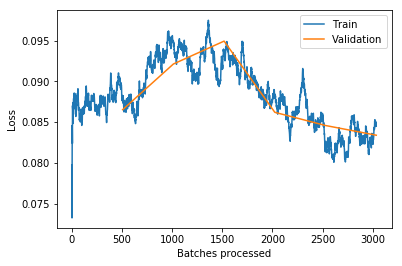

In [55]:
learn.recorder.plot_losses()

In [67]:
# learn.save('rn34-stg2-sz128-final6')
learn.load('rn34-stg2-sz128-final6');

### size 256 stage 1

In [68]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


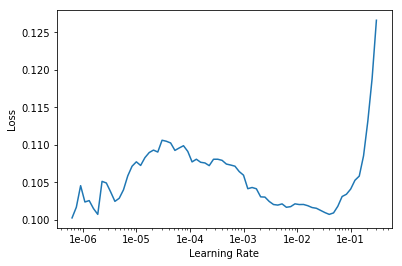

In [69]:
learn.freeze()
learn.lr_find(); learn.recorder.plot()

In [70]:
# lr = 5e-3 # 1e-2/2
lr = 1e-3/2

In [71]:
learn.fit_one_cycle(6, slice(lr))

Total time: 18:01
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.092175    0.092753    0.954969         0.917163  (03:00)
2      0.088659    0.089429    0.956735         0.920847  (03:00)
3      0.089653    0.088090    0.955143         0.922024  (03:00)
4      0.086945    0.089202    0.955317         0.922959  (03:00)
5      0.087637    0.086914    0.955884         0.923543  (03:00)
6      0.090977    0.088331    0.956059         0.923450  (03:00)



In [72]:
learn.save('rn34-stg1-sz256-final6')
# learn.load('rn34-stg1-sz256-final6')

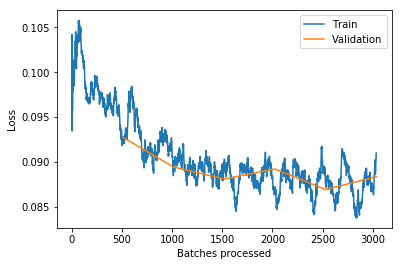

In [73]:
learn.recorder.plot_losses()

The below LR plot is over the entire cycle:

In [79]:
learn.data.train_dl.batch_size

64

In [80]:
len(learn.data.items) / learn.data.train_dl.batch_size

506.0

In [81]:
6*(len(learn.data.items) / learn.data.train_dl.batch_size)

3036.0

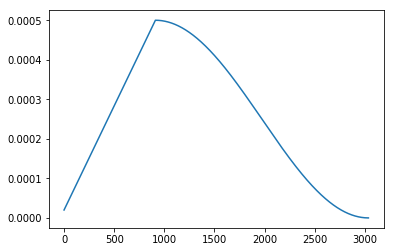

In [75]:
learn.recorder.plot_lr()

In [82]:
learn.fit_one_cycle(4, slice(lr/10))

Total time: 12:01
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.090083    0.087753    0.956495         0.924188  (02:59)
2      0.087197    0.088117    0.954990         0.923526  (03:00)
3      0.088101    0.088441    0.956429         0.923826  (03:00)
4      0.088527    0.087926    0.956393         0.923717  (03:00)



In [83]:
learn.save('rn34-stg1x4-sz256-final6')

In [84]:
learn.fit_one_cycle(6, slice(lr/10))

Total time: 18:01
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.089692    0.086767    0.955797         0.923148  (02:59)
2      0.087220    0.087514    0.956575         0.924074  (03:00)
3      0.088028    0.086728    0.955993         0.923975  (03:00)
4      0.087532    0.086541    0.956022         0.924155  (03:00)
5      0.086538    0.086079    0.956407         0.924687  (03:00)
6      0.085569    0.086713    0.956008         0.924590  (03:00)



In [85]:
learn.save('rn34-stg1x10-sz256-final6')

### size 256 stage 2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


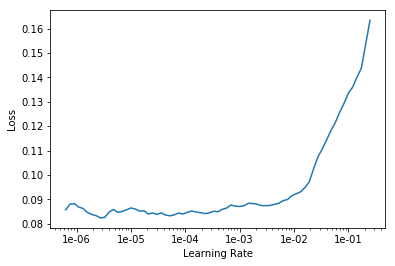

In [86]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [89]:
lr

0.0005

In [90]:
lr = 1e-3

In [91]:
learn.fit_one_cycle(6, slice(lr/9, lr))

Total time: 24:21
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.086966    0.085785    0.956996         0.924768  (04:03)
2      0.087338    0.085624    0.954918         0.925705  (04:03)
3      0.085337    0.084259    0.957890         0.927464  (04:03)
4      0.082347    0.083460    0.958508         0.928191  (04:03)
5      0.081553    0.082440    0.957686         0.928207  (04:03)
6      0.083812    0.082568    0.958297         0.928943  (04:03)



In [92]:
learn.save('rn34-stg2-sz256-final6')

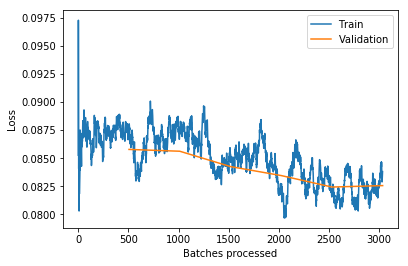

In [93]:
learn.recorder.plot_losses()

extra training

In [94]:
learn.fit_one_cycle(6, slice(lr/3/9, lr/3))

Total time: 24:20
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.084073    0.082719    0.958232         0.928159  (04:02)
2      0.085781    0.083240    0.957759         0.926437  (04:03)
3      0.083072    0.083214    0.957955         0.927857  (04:03)
4      0.082405    0.082067    0.958943         0.928977  (04:03)
5      0.080113    0.082106    0.958616         0.928705  (04:03)
6      0.080632    0.082290    0.958289         0.929070  (04:03)



In [95]:
learn.save('rn34-stg2x6-sz256-final6')

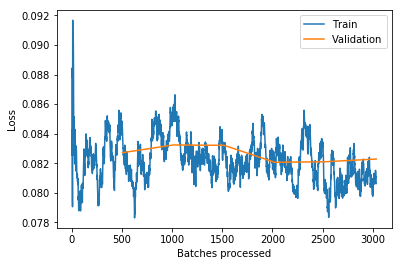

In [96]:
learn.recorder.plot_losses()

In [97]:
learn.fit_one_cycle(6, slice(lr/4/25, lr/4)) # bumping up the magnitude from 3 to 5

Total time: 24:30
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.080580    0.082889    0.958616         0.928827  (04:02)
2      0.083681    0.081899    0.958151         0.929158  (04:03)
3      0.080110    0.082087    0.958079         0.929015  (04:03)
4      0.081136    0.081945    0.958173         0.928912  (04:03)
5      0.080232    0.082037    0.959387         0.929268  (04:03)
6      0.078764    0.081934    0.958013         0.929023  (04:14)



In [101]:
# learn.save('rn34-stg2x12-sz256-final6')
learn.load('rn34-stg2x12-sz256-final6');

In [99]:
# learn.fit_one_cycle(6, slice(lr/8/36, lr/8))

Total time: 24:51
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.083286    0.081851    0.958246         0.928988  (04:02)
2      0.080838    0.081932    0.959176         0.929701  (04:18)
3      0.080951    0.082111    0.958486         0.928684  (04:03)
4      0.080637    0.081710    0.958188         0.929278  (04:03)
5      0.079468    0.081866    0.958820         0.929158  (04:03)
6      0.080662    0.082028    0.958740         0.928782  (04:19)



In [131]:
learn.load('rn34-stg2x6-sz256-final6');

## Predictions

In [132]:
subm_df = pd.read_csv(path/'sample_submission_v2.csv')
subdic = {c1:c2 for c1,c2 in zip(subm_df.image_name,subm_df.tags)}

In [133]:
def set_test_datafolder(learner, test_folder):
    learner.data = (src.add_test_folder(test_folder)
                    .transform(tfms, size=256)
                    .databunch().normalize(imagenet_stats))

1st testset portion

In [134]:
set_test_datafolder(learn, 'test-jpg')
fnames = [f.name.split('.')[0] for f in learn.data.test_ds.x.items]

In [135]:
preds1 = learn.TTA(ds_type=DatasetType.Test)

Total time: 12:02



2nd testset portion

In [136]:
set_test_datafolder(learn, 'test-jpg-additional')
fnames.extend([f.name.split('.')[0] for f in learn.data.test_ds.x.items])

In [137]:
preds2 = learn.TTA(ds_type=DatasetType.Test)

Total time: 06:11



In [138]:
preds = (torch.cat((preds1[0],preds2[0])), torch.cat((preds1[1],preds2[1])))

saving results to disk

In [172]:
# torch.save(preds, f'rn34-stg2x6-sz256-final6.pkl')
preds = torch.load(f'rn34-stg2x12-sz256-final6.pkl')

In [167]:
# torch.save(preds, f'planet-rn34-sz256-stg2-aggr-x-rsz64.pkl')
# preds = torch.load(f'planet-rn34-sz256-stg2-aggr-x-rsz64.pkl')

## Submissions

In [140]:
import datetime
date = str(datetime.date.today()).replace('-','')

In [141]:
idx2class = {v:k for k,v in learn.data.c2i.items()}

In [179]:
th = 0.5

for i,fn in enumerate(fnames):
    subdic[fn] = ' '.join(idx2class[cdx] for cdx in np.where(preds[0][i]>=th)[0])
    
subm_col = [subdic[fn] for fn in subm_df.image_name]
subm_df.tags = subm_col

In [180]:
sub_msg = f"fastai {__version__}; rn34 2-stgx12; final-rsz64; thresh:{th}; {date}"

In [181]:
sub_name = f'planet-rn34-sz256-stg2x6-final-rsz64_{date}_th{str(th).replace(".","")}.csv'
subm_df.to_csv(path/'submissions/'/sub_name, index=False, )
! kaggle competitions submit -c planet-understanding-the-amazon-from-space -f {path}/submissions/{sub_name} -m "{sub_msg}"

100%|██████████████████████████████████████| 1.87M/1.87M [00:00<00:00, 2.35MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

## Results

threshold | aggr-64 | aggrx64 | final12 | final6
--------  | ------- | ------- | ------- | ------- |
0.500     | ------- | ------- | 0.89347 | ------- |
0.450     | ------- | ------- | 0.90318 | 0.90195 |
0.400     | ------- | ------- | 0.89950 | 0.90518 |
0.350     | 0.91196 | 0.91285 | 0.88482 | 0.88791 |
0.300     | 0.91741 | 0.91782 | 0.88531 | 0.88617 |
0.250     | 0.91768 | 0.91592 | 0.88575 | 0.88594 |
0.200     | 0.90583 | 0.90204 | 0.88448 | 0.88528 |
0.150     | 0.89385 | ------- | 0.87501 | 0.87851 |

### previous results

training for 1 6-length cycle for each stage with 2 sizes (20% val out):

    thres    aggr1  -  aggr2  -  aggr2x
    0.400 - ------- - 0.90992 - -------
    0.350 - ------- - 0.91524 - 0.91519
    0.300 - 0.91920 - 0.91341 - 0.91417
    0.275 - ------- - ------- - -------
    0.250 - 0.92314 - 0.88908 - 0.89742
    0.225 - ------- - ------- - -------
    0.200 - 0.92532 - 0.88367 - 0.88705
    0.180 - 0.92532 - ------- - -------
    0.150 - 0.92428 - ------- - -------

All results @80% train:

threshold| norm1   |  aggr1  |  aggr1x |  aggr2  |  aggr2x
 ------- | ------- | ------- | ------- | ------- | ------- 
   0.400 | ------- | ------- | ------- | 0.90992 | -------
   0.350 | ------- | ------- | 0.91230 | 0.91524 | 0.91519
   0.300 | 0.92206 | 0.91920 | 0.91757 | 0.91341 | 0.91417
   0.250 | 0.92546 | 0.92314 | 0.92074 | 0.88908 | 0.89742
   0.200 | 0.92601 | 0.92532 | 0.92278 | 0.88367 | 0.88705
   0.180 | ------- | 0.92532 | ------- | ------- | -------
   0.150 | 0.92329 | 0.92428 | 0.92210 | 0.92329 | ------- 

Results:

threshold | normal-pvt-score | aggr-1-pvt-score
-|-|-
0.3|0.92206|0.91920
0.25|0.92546|0.92314
0.2|0.92601|0.92532
0.15|0.92329|0.92428

Final metrics:

model|train_loss | valid_loss | accuracy_thresh | fbeta
-|-|-|-|-
norm-1|0.076459  |  0.080886  |  0.964379    |     0.929328
aggr-1|0.086619  |  0.087704  |  0.961886    |     0.926379

Training schedule:

stage|norm-1 6len-cycle dlr|aggr-1 6len-cycle dlr
-|-|-
size128-1|0.01|0.01
size128-2|1e-5, 1.414214e-4, 0.002|5.56e-4, 0.001667, 0.005 
size256-1|0.005|0.01
size256-2|1e-5, 4.472136e-5, 2e-4|1.11e-4, 3.33e-4, 0.001

In [ ]:
learn.lr_range(slice(1e-5, 1e-2/5))

################################################################################

## end